In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label, remove_small_objects
from skimage.measure import regionprops
from skimage.io import imread
from skimage.color import label2rgb
from topostats.theme import Colormap

In [2]:
cmap = Colormap('nanoscope').get_cmap()

def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

# Load image and optionally flatten and save (for manual masking)

[Mon, 17 Apr 2023 19:05:25] [INFO    ] [topostats] Extracting image from Folded/20230126_KPN005.0_00026.spm
[Mon, 17 Apr 2023 19:05:25] [INFO    ] [topostats] Loading image from : Folded/20230126_KPN005.0_00026.spm
[Mon, 17 Apr 2023 19:05:25] [INFO    ] [topostats] [20230126_KPN005.0_00026] : Loaded image from : Folded/20230126_KPN005.0_00026.spm
[Mon, 17 Apr 2023 19:05:25] [INFO    ] [topostats] [20230126_KPN005.0_00026] : Extracted channel Height
[Mon, 17 Apr 2023 19:05:25] [INFO    ] [topostats] [20230126_KPN005.0_00026] : Pixel to nm scaling : 5.6396484375


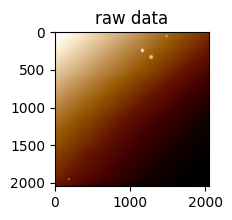

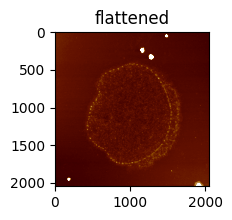

In [38]:
#file = Path('./Folded/20221215_KDNA011.0_00007.spm')
# file = Path('./Folded/20230118_KPN001.0_00007.spm')
#file = Path('./Folded/20230118_KPN001.0_00009.spm')
#file = Path('./Folded/20230118_KPN001.0_00020.spm')
#file = Path('./Folded/20230118_KPN001.0_00027.spm')
#file = Path('./Folded/20230124_KPN004.0_00006.spm')
#file = Path('./Folded/20230124_KPN004.0_00009.spm')
#file = Path('./Folded/20230124_KPN004.0_00019.spm')
#file = Path('./Folded/20230125_KPN005.0_00024.spm')
file = Path('./Folded/20230126_KPN005.0_00026.spm')

# Load the data
loadscans = LoadScans([file], channel='Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plot(image_raw, title='raw data', zlimit=False, figsize=(2, 2))
image = image_raw.copy()

# Optionally flatten image
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False},
    quiet=True
)
filters.filter_image()
image = filters.images['zero_average_background']
plot(image, title='flattened', figsize=(2, 2))

# Optionally save the image for manual masking externally
#out_dir = Path('./manual_masking_images/')
#out_dir.mkdir(exist_ok=True)
#plt.imsave(out_dir / 'to_be_masked.png', image)

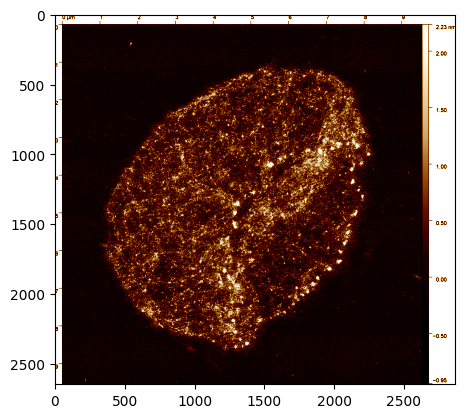

In [3]:
# Manually load an image instead of loading an spm and flattening
file = './fibril_experiment/img4_20230118_KPN001_25mMMgCl2_Vac(2).0_00020.png'
p_to_nm = 100 # Need to manually set the pixel to nanometre scaling factor
image = imread(file, as_gray=True)
plt.imshow(image, cmap=cmap)

(2048, 2048)


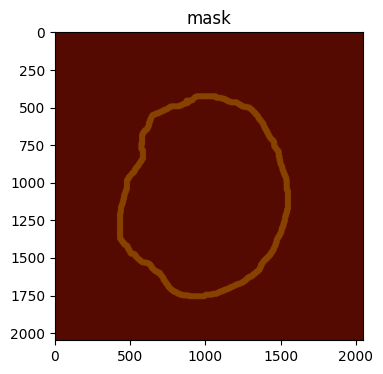

In [39]:
# Manually load mask
# mask_path = Path('./manual_masking_images/KDNA_11.png')
# mask_path = Path('./manual_masking_images/KPN001_07.png')
# mask_path = Path('./manual_masking_images/KPN001_09.png')
# mask_path = Path('./manual_masking_images/KPN001_20.png')
# mask_path = Path('./manual_masking_images/KPN001_27.png')
# mask_path = Path('./manual_masking_images/KPN004_06.png')
# mask_path = Path('./manual_masking_images/KPN004_09.png')
# mask_path = Path('./manual_masking_images/KPN005_19.png')
# mask_path = Path('./manual_masking_images/KPN005_24.png')
mask_path = Path('./manual_masking_images/KPN005_26.png')

mask = imread(mask_path)
mask = mask.astype(bool)
print(mask.shape)
plot(mask, title='mask', figsize=(4, 4))

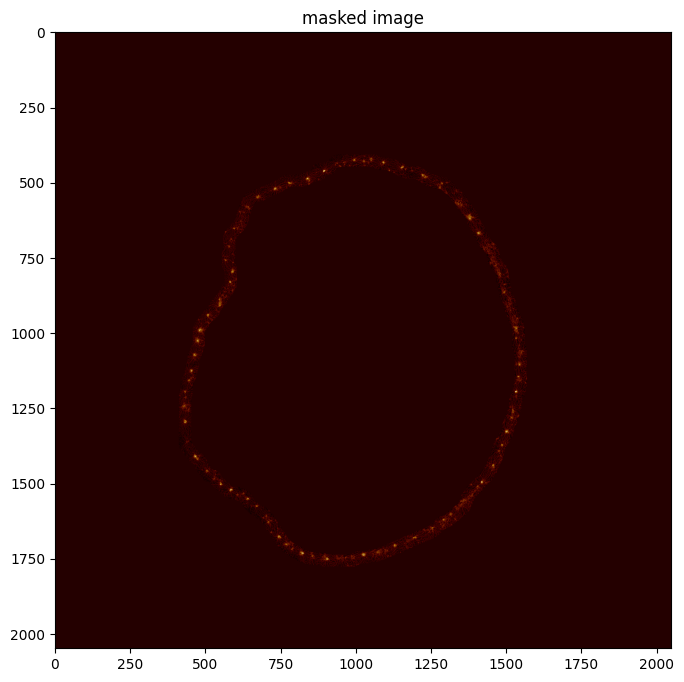

In [40]:
# Apply the mask to the image
masked = np.ma.masked_array(data=image, mask=np.invert(mask), fill_value=0).filled()
plot(masked, title='masked image', zlimit=False)

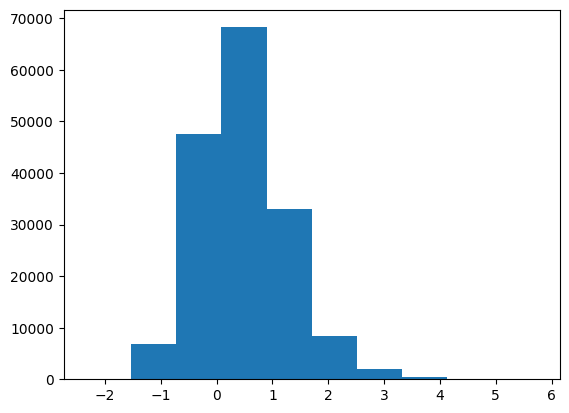

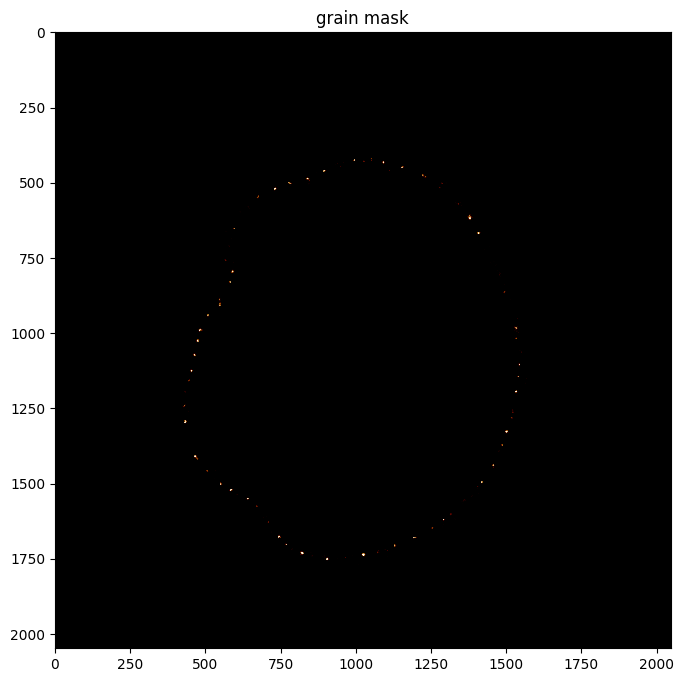

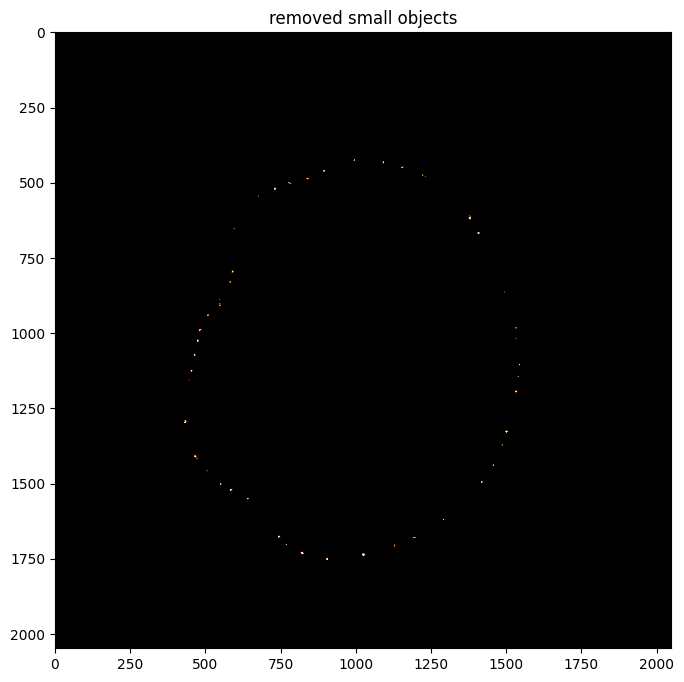

In [52]:
# mask the image within the defined masked region for nodes

std_dev_multiplier = 10
plt.hist(masked[masked != 0.0])
threshold = np.mean(masked[masked != 0.0]) + np.std(masked) * std_dev_multiplier
grain_mask = masked > threshold
plot(grain_mask, title='grain mask', zlimit=False)
removed_small_objects = remove_small_objects(grain_mask, 15)
plot(removed_small_objects, title='removed small objects', zlimit=False)
labelled = label(removed_small_objects)
#coloured_labels = label2rgb(labelled, bg_label=0)
#plot(coloured_labels, title='labelled')

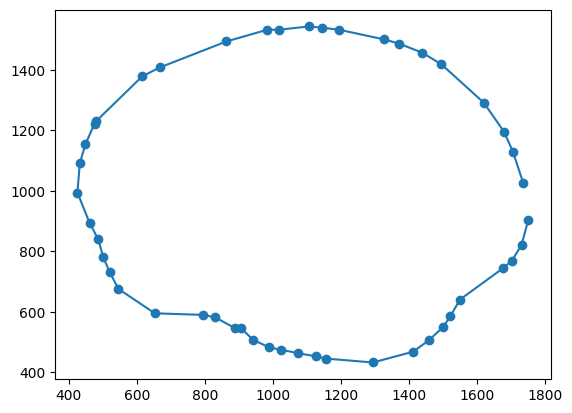

In [271]:
def get_points(binary_img) -> tuple:
    labelled = label(binary_img)
    regions = regionprops(labelled)
    points = np.ndarray((len(regions), 2))
    for props_index, props in enumerate(regions):
        points[props_index, :] = props.centroid

    return points

points = get_points(labelled)

centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point, centroid) for point in points])]


xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

plt.scatter(sorted[:, 0], sorted[:, 1])
plt.plot(sorted[:, 0], sorted[:, 1])

In [46]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    max_heights = np.zeros(len(region_props))
    mean_heights = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume
        max_heights[props_index] = np.max(region_values)
        mean_heights[props_index] = np.mean(region_values)

    return {
        'areas': areas,
        'volumes': volumes,
        'max_heights': max_heights,
        'mean_heights': mean_heights,
        'number_of_regions': len(region_props),
    }

In [ ]:
def interpolate_for_curvature(points: np.ndarray, interpolation_points: int):
    interpolated_points = np.zeros((2, points.shape[1] * (interpolation_points + 1)))

    for index, point in enumerate(points):
        print(f'index: {index}')
        print(f'point: {point}')

        # linearly interpolate between the two points



    return interpolated_points

In [60]:
#Output statistics

from network_stats import network_feret_diameters, get_triangle_height, is_clockwise, network_area, polygon_perimeter, rim_curvature

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

print('Image:',file)

print('- molecule stats -')
area = network_area(sorted)* P_TO_MICRON**2
print(f'area: {area:.2f} μm^2')
perimeter = polygon_perimeter(sorted)* P_TO_MICRON
print(f'perimeter: {perimeter:.2f} μm')
min_feret, max_feret = network_feret_diameters(sorted)
print(f'min_feret: {min_feret* P_TO_MICRON:.2f} μm | max_feret: {max_feret* P_TO_MICRON:.2f} μm')
regionstats = region_stats(labelled_image=labelled, image=image)
curvature_all_nodes = rim_curvature(sorted[:, 1], sorted[:, 0])
print(f'mean_curvature: {np.mean(curvature_all_nodes)}')
print(f'sum_curvature: {np.sum(curvature_all_nodes)}')

print('- node stats -')
num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
print(f'node areas | min: {np.min(regionstats["areas"]* p_to_nm**2):.2f} nm^2 max: {np.max(regionstats["areas"]* p_to_nm**2):.2f} nm^2 mean: {np.mean(regionstats["areas"]* p_to_nm**2):.2f} nm^2')
print(f'node volumes | min: {np.min(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 max: {np.max(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 mean: {np.mean(regionstats["volumes"]* p_to_nm**2):.2f} nm^3')
print(f'mean node height values | min: {np.min(regionstats["mean_heights"]):.2f} nm max: {np.max(regionstats["mean_heights"]):.2f} nm mean: {np.mean(regionstats["mean_heights"]):.2f} nm')
print(f'max node height values | min: {np.min(regionstats["max_heights"]):.2f} nm max: {np.max(regionstats["max_heights"]):.2f} nm mean: {np.mean(regionstats["max_heights"]):.2f} nm\n')

print('Full Curvature Values:')
print(curvature_all_nodes,"\n")
print("---------------------------------------------------------------")

Image: Folded/20230126_KPN005.0_00026.spm
- molecule stats -
area: 35.01 μm^2
perimeter: 21.56 μm
min_feret: 6.03 μm | max_feret: 7.51 μm
47
mean_curvature: 0.0026947295849554975
sum_curvature: 0.12665229049290838
- node stats -
number of nodes in perimeter: 47
node areas | min: 508.89 nm^2 max: 3021.54 nm^2 mean: 1381.85 nm^2
node volumes | min: 1441.18 nm^3 max: 9250.45 nm^3 mean: 4229.48 nm^3
mean node height values | min: 2.57 nm max: 3.65 nm mean: 3.03 nm
max node height values | min: 2.90 nm max: 5.74 nm mean: 4.36 nm

Full Curvature Values:
[1.28485069e-03 1.80755771e-03 2.62243096e-03 8.55375322e-04
 1.22134859e-03 3.67138133e-03 2.79706388e-03 6.75178511e-04
 4.66332556e-04 4.77862461e-03 1.22952611e-03 1.94975113e-03
 2.49275132e-03 3.19587428e-04 1.37086838e-03 1.56190012e-03
 1.08998166e-03 1.15845972e-02 1.79401102e-03 3.09969768e-03
 2.13893321e-03 1.49710728e-03 7.38214877e-04 5.65240565e-04
 6.22682093e-03 4.44495638e-03 1.86654243e-03 9.63155439e-04
 5.96528333e-03 1.7

47
47


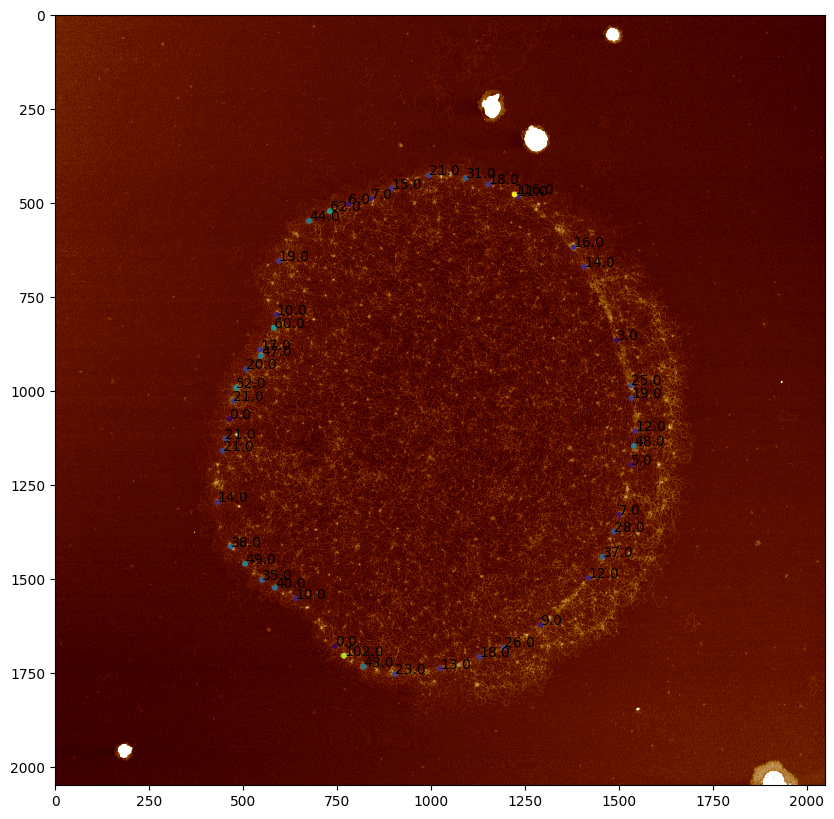

In [91]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image, cmap=cmap, vmin=-3, vmax=4)
# plt.plot(sorted[:, 1], sorted[:, 0])
min_curvature = np.min(curvature_all_nodes)
max_curvature = np.max(curvature_all_nodes)
range_curvature = max_curvature - min_curvature
colour_multiplier = 1 / range_curvature
colours = curvature_all_nodes * colour_multiplier
print(len(sorted))
print(len(colours))
# height_capped_curvatures = np.clip(curvature_all_nodes, 0, 0.01)
ax.scatter(sorted[:, 1], sorted[:, 0], c=curvature_all_nodes, s=10)
for index, node in enumerate(sorted):
    plt.text(node[1], node[0], f'{np.around(curvature_all_nodes[index]*10000, 0)}')
plt.show()

10
[0.03600559 1.49575497 0.80383819 0.55026583 0.12539718 0.12539718
 0.55026583 0.80383819 1.49575497 0.03600559]


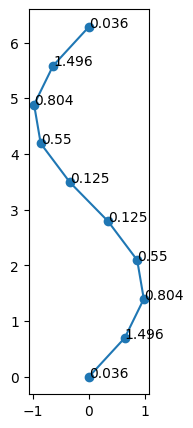

In [302]:
# arr = np.array([
#     [0, 0],
#     [2, 3],
#     [3, 4],
#     [4, 3],
#     [8, 4],
#     [4, 2],
#     [3, 2],
#     [1, 0.5],
# ])

# arr = np.array([
#     [0, 0],
#     [1, 0],
#     [1, 0.1],
#     [1, 0.15],
#     [1, 0.2],
#     [1, 0.25],
#     [1, 0.5],
#     [1, 0.75],
#     [1, 0.8],
#     [1, 1],
#     [0, 1],
# ])

arr = np.zeros((10, 2))
xvals = np.linspace(0, 2*np.pi, arr.shape[0])
vals = np.sin(xvals)
arr[:, 0] = vals
arr[:, 1] = xvals

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(arr[:, 0], arr[:, 1])
ax.plot(arr[:, 0], arr[:, 1])
ax.set_aspect(1)


curvatures = rim_curvature(arr[:, 0], arr[:, 1])
print(curvatures)
for index, node in enumerate(arr):

    ax.text(node[0], node[1], f'{np.around(curvatures[index], 3)}')


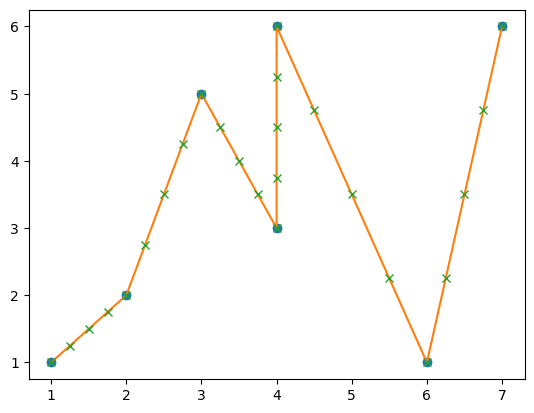

In [212]:

def interpolate_between_two_points(p1, p2, interpolation_number):
    # get x and y values of each point
    x1, y1 = p1
    x2, y2 = p2
    
    if x1 == x2:
        # if the two points have the same x-coordinate,
        # generate n equally spaced y-coordinates instead
        y = np.linspace(y1, y2, interpolation_number+1)
        x = [x1] * 5
    else:
        # generate n equally spaced points between p1 and p2
        x = np.linspace(x1, x2, interpolation_number+1)
        y = np.linspace(y1, y2, interpolation_number+1)
    
    # combine x and y values to get the interpolated points
    points = np.column_stack((x[1:-1], y[1:-1]))

    return points

def interpolate_set_of_points(points: np.ndarray, interpolation_number: int):

    interpolated_points = np.zeros(((points.shape[0] - 1) * interpolation_number + 1, 2))
    for index in range(points.shape[0]):
        interpolated_points[index*interpolation_number, :] = points[index]
    # print(interpolated)
    for index in range(points.shape[0]-1):

        interp = interpolate_between_two_points(points[index], points[index+1], interpolation_number=interpolation_number)

        interpolated_points[index*interpolation_number, :] = points[index]
        for i in range(interp.shape[0]):
            interpolated_points[index*interpolation_number + i+1, :] = interp[i]

    return interpolated_points


points = np.array([
    [1, 1],
    [2, 2],
    [3, 5],
    [4, 3],
    [4, 6],
    [6, 1],
    [7, 6],
])

interpolated = interpolate_set_of_points(points, interpolation_number=4)

plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(points[:, 0], points[:, 1])
plt.plot(interpolated[:, 0], interpolated[:, 1], 'x')

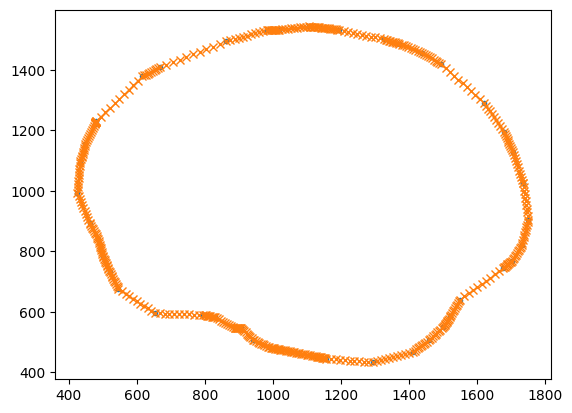

471


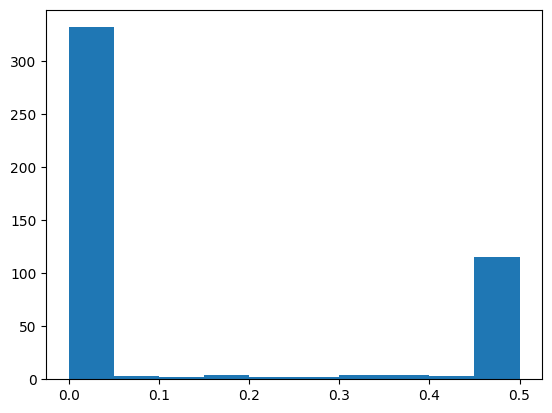

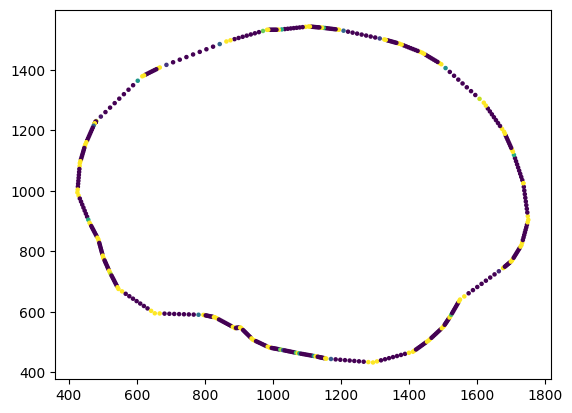

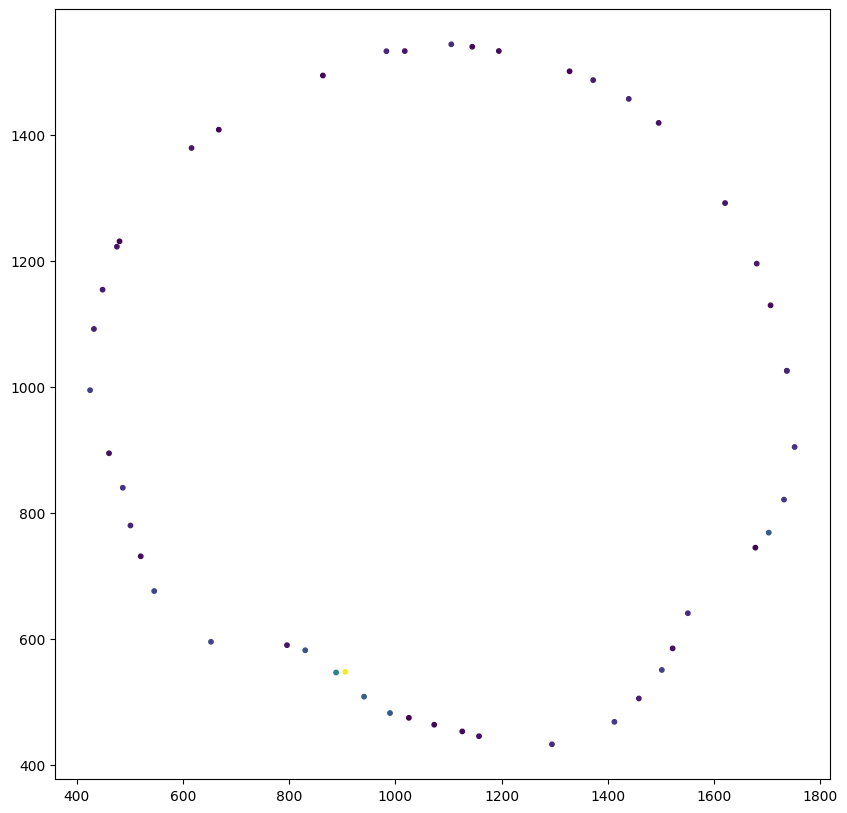

In [321]:
a_sorted = np.append(sorted, [sorted[0]], axis=0)
plt.plot(a_sorted[:, 0], a_sorted[:, 1], '.')
interpolated = interpolate_set_of_points(a_sorted, interpolation_number=10)
plt.plot(interpolated[:, 0], interpolated[:, 1], 'x')
plt.show()
curv = rim_curvature(interpolated[:, 0], interpolated[:, 1])
scaled_curv = curv - np.min(curv)
scaled_curv = (scaled_curv / np.max(scaled_curv)) * 255
scaled_curv = np.clip(scaled_curv, 0, 0.5)
plt.hist(scaled_curv, bins=10)
plt.show()

# colour_scaled_curv = curv / (np.max(curv) - np.min(curv))
# colour_scaled_curv = np.clip(colour_scaled_curv, 0, 0.01)
# for index, point in enumerate(interpolated):
#     plt.plot(point[0], point[1], marker='.', c=colour_scaled_curv[index])
plt.scatter(interpolated[:, 0], interpolated[:, 1], c=scaled_curv, s=5)
plt.show()

skipped_interpolated = interpolated[::10]
skipped_curv = curv[::10]
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(skipped_interpolated[:, 0], skipped_interpolated[:, 1], c=skipped_curv, s=10)